## Import libraries


In [1]:
# %pip install "segment-geospatial[samgeo3]"

In [214]:
import os
from glob import glob

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pyproj
import rasterio as rio
from pyproj import Transformer
from rasterio.features import shapes
from rasterio.transform import rowcol
from samgeo import SamGeo3
from scipy.ndimage import binary_fill_holes
from shapely.geometry import shape
from skimage.morphology import (
    binary_closing,
    binary_opening,
    disk,
    remove_small_objects,
)

# from huggingface_hub import login
# login()

data_dir = "/beegfs/halder/GITHUB/RESEARCH/WBCrop/data"

## Define the data path


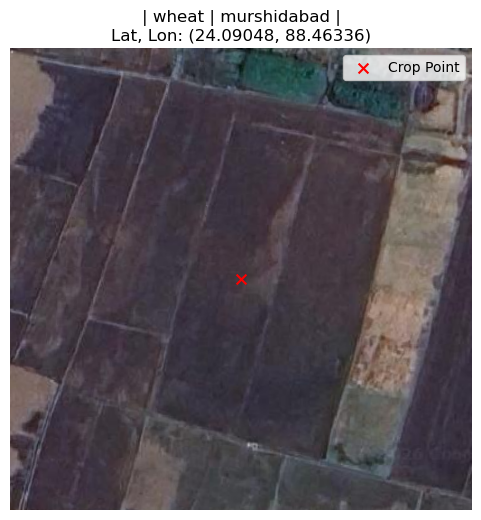

In [215]:
# Read the point shapefile
crop_samples_gdf = gpd.read_file(
    os.path.join(data_dir, "processed", "wbcrop_points.gpkg")
)

# Read the image paths
image_paths = glob(
    os.path.join(data_dir, "raw", "high_res_patches", "high_res_patches", "*.tif")
)
# image_path = np.random.choice(image_paths)
image_path = image_paths[250]
image_id = int(os.path.basename(image_path).split("_")[0])
point_info = crop_samples_gdf.loc[crop_samples_gdf["id"] == image_id].iloc[0]
crop, district = point_info["crop"], point_info["district"]
lat, lon = float(point_info["latitude"]), float(point_info["longitude"])

with rio.open(image_path, "r") as src:
    rgb = src.read([1, 2, 3])
    rgb = np.transpose(rgb, (1, 2, 0))
    meta = src.meta
    transform = src.transform

transformer = Transformer.from_crs("EPSG:4326", src.crs, always_xy=True)
x_proj, y_proj = transformer.transform(lon, lat)
row, col = rowcol(transform, x_proj, y_proj)

plt.figure(figsize=(6, 6))
plt.imshow(rgb)
plt.scatter(col, row, color="red", s=50, marker="x", label="Crop Point")
plt.legend()
plt.title(f"| {crop} | {district} |\nLat, Lon: ({lat:.5f}, {lon:.5f})")
plt.axis("off")
plt.show()

## Initialize SAM3


In [159]:
sam3 = SamGeo3(
    backend="meta",
    device="cuda",
    checkpoint_path=None,
    load_from_HF=True,
    enable_inst_interactivity=True,
)

Using cuda device and meta backend


## Set the image


In [216]:
sam3.set_image(image_path)

## Generate mask with point prompt


Found one object.


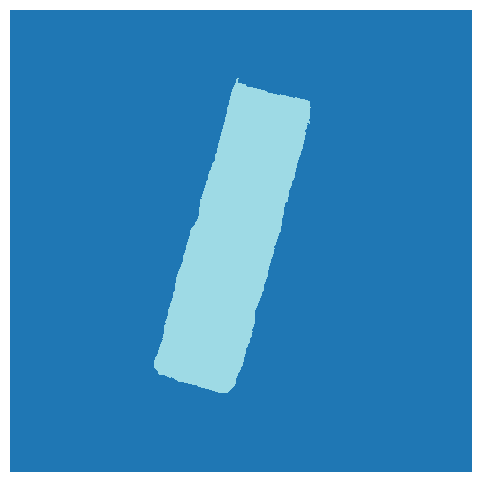

In [217]:
row = int(row)
col = int(col)
point_coords = np.array([[col, row]])

sam3.generate_masks_by_points(point_coords, min_size=100)

sam3.show_masks(figsize=(6, 6))

## Save the mask


In [218]:
sam3.save_masks(output="field_masks_binary.tif", unique=False)

Saved 1 mask(s) to field_masks_binary.tif


## Process the mask


### Noise reduction


In [219]:
# Read the mask
with rio.open("field_masks_binary.tif", "r") as src:
    mask = src.read(1)
    meta = src.meta

mask = mask.astype(bool)

# Remove small patches
min_size = int((mask.shape[0] * mask.shape[1]) * 0.02)  # <2% area
mask_cleaned = remove_small_objects(mask, min_size=min_size)

# Morphological opening (remove salt noise)
mask_cleaned = binary_opening(mask_cleaned, disk(3))

# Morphological closing (fill small gaps)
mask_cleaned = binary_closing(mask_cleaned, disk(3))

# Fill holes inside fields
mask_cleaned = binary_fill_holes(mask_cleaned)

mask_cleaned = mask_cleaned.astype(np.uint8)

# Save the cleaned mask
meta.update({"dtype": "uint8", "count": 1, "compress": "lzw"})

# Save
with rio.open("field_masks_binary_cleaned.tif", "w", **meta) as dst:
    dst.write(mask_cleaned, 1)

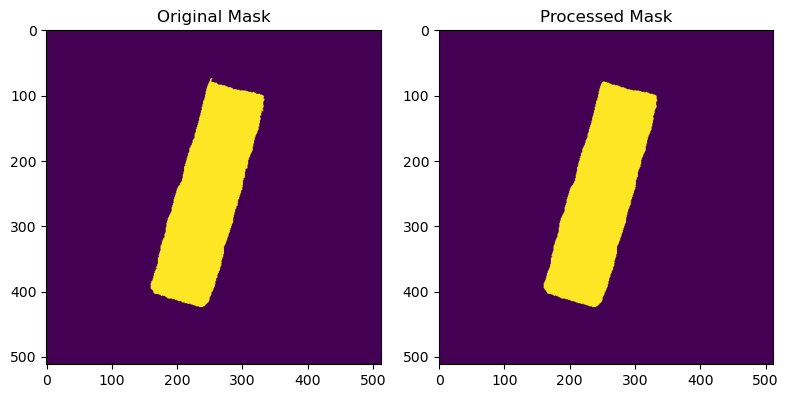

In [220]:
# Plot the data
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(4 * 2, 4))
axes = axes.flatten()

axes[0].imshow(mask)
axes[1].imshow(mask_cleaned)

axes[0].set_title("Original Mask")
axes[1].set_title("Processed Mask")

plt.tight_layout()
plt.show()

### Raster to vector


<Axes: >

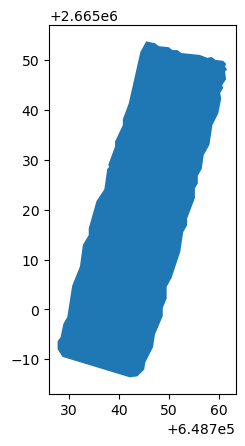

In [221]:
# Read the cleaned mask
with rio.open("field_masks_binary_cleaned.tif") as src:
    mask_cleaned = src.read(1)
    meta = src.meta

    results = (
        {"properties": {"value": v}, "geometry": s}
        for s, v in shapes(mask_cleaned, transform=transform)
        if v == 1
    )

geoms = [shape(r["geometry"]) for r in results]
gdf = gpd.GeoDataFrame(geometry=geoms, crs=src.crs)
gdf["area"] = gdf.geometry.area
gdf = gdf[gdf["area"] > 50]  # area in CRS units
gdf = gdf.dissolve()
gdf["geometry"] = gdf.geometry.simplify(tolerance=0.25)

gdf.plot()